In [1]:
# 1. Các thư viện cần thiết
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
# 2. Đọc file dữ liệu chứng khoán Eximbank và chia tập train test theo tỉ lệ 9:1
df = pd.read_csv('Eximbank.csv')
df = df[['Close', 'High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

train_size = int(0.9 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [3]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Tìm mô hình ARIMA phù hợp nhất bằng auto_arima 
auto_arima(train_data['Close'], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16858.870, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16870.575, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16857.590, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16859.010, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16868.880, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16856.801, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16858.105, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16857.371, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16855.842, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16857.394, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16857.375, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16854.016, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16857.252, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16855.821, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [4]:
model = VARMAX(train_data, order=(1, 1))
model_fit = model.fit(maxiter=1000, disp=False)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [5]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
close_pred = model_fit.forecast(steps=len(y_test))
y_pred = close_pred['Close'].to_numpy()

In [6]:
# 5. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Tạo một mảng gồm 30 số nguyên liên tiếp bắt đầu từ last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá đóng cho 30 ngày tiếp theo
close_next_30_days = model_fit.forecast(steps=len(x_next_30_days))

y_next_30_days = close_next_30_days['Close'].to_numpy()

# In ra giá đóng đã được dự đoán trong 30 ngày tiếp theo
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[20352.09820086 20340.42708399 20330.02096455 20320.13164673
 20310.45891421 20300.88229517 20291.35343735 20281.85292536
 20272.37295426 20262.91037763 20253.46391826 20244.03304891
 20234.61754331 20225.21729597 20215.83224988 20206.4623675
 20197.10761913 20187.76797824 20178.44341959 20169.1339185
 20159.83945052 20150.55999131 20141.29551662 20132.04600224
 20122.811424   20113.5917578  20104.38697955 20095.1970652
 20086.02199076 20076.86173226]


In [7]:
# 6. Tính độ đo RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 1590.236044285172


In [8]:
# 7. Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))*100
print('Testing MAPE:', test_mape)

Testing MAPE: 7.391297946846775


In [9]:
# 8. Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - y_test))
print('Testing MAE:', test_mae)

Testing MAE: 1345.0887060582306


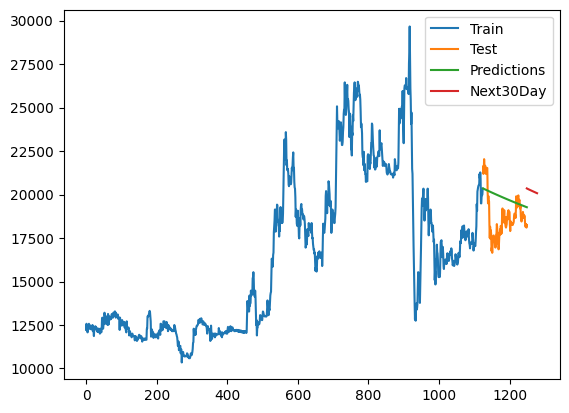

In [10]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

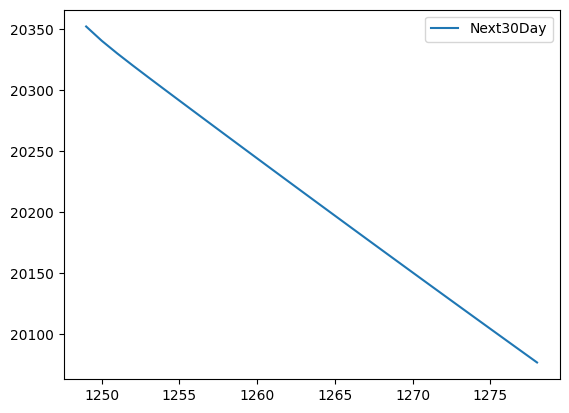

In [11]:
plt.plot(last_data,y_next_30_days)
plt.legend(['Next30Day'])
plt.show()